In [1]:
import numpy as np
from pulp import LpProblem, LpMinimize, LpVariable, LpMaximize, LpStatus, LpInteger
import sympy as sym
import random

In [2]:
colors = dict(android_green = "#2BE68F")

## Транспортная задача - ЛП метод

In [3]:
def solve_transport_lp_method(C, A, B):
    i_s = ord('a')
    n, m = C.shape
    # Переменные
    X = np.array(list(LpVariable(f'{chr(i)}', lowBound=0, cat=LpInteger) for i in range(i_s, i_s + n * m)))\
        .reshape((n, m))

    # Целевая функция
    F = (C * X).sum()

    le = np.vectorize(lambda x, y: x <= y)
    eq = np.vectorize(lambda x, y: x == y)

    # Ограничения запасов
    C1 = le(X.sum(axis=1), A)
    # Ограничения потребностей
    C2 = eq(X.sum(axis=0), B)

    model = LpProblem("Distribution_Problem", LpMinimize)
    model += F
    for i in [C1, C2]:
        for j in i:
            model += j

    model.solve()


    X_star = np.vectorize(lambda x: x.value())(np.array(model.variables()))

    print('Оптимальный план перевозки:')
    print(X_star.reshape((n, m)))

    print(f'Оптимальная стоимость перевозки: {model.objective.value()}')

In [4]:

# Размерность матрицы
n = 3
m = 4

C = np.array([
    [4, 1000, 5, 5],
    [13, 16, 18, 9],
    [14, 23, 1000, 7]
])

# Запасы
A = np.array([40, 100, 210])

# Потребности
B = np.array([190, 10, 70, 80])

In [5]:
solve_transport_lp_method(C, A, B)

Оптимальный план перевозки:
[[  0.   0.  40.   0.]
 [ 60.  10.  30.   0.]
 [130.   0.   0.  80.]]
Оптимальная стоимость перевозки: 4060.0


## Метод ЛП

In [6]:
class LP:
    def __init__(self, D, F, a=1, b=1, c=1):
        self.a = a
        self.b = b
        self.c = c
        self.s_F = F

        if not isinstance(F, sym.Add):
            self.F = sym.parse_expr(F).subs(dict(a=a, b=b, c=c))
        else:
            self.F = F


        if not isinstance(D, np.ndarray):
            self.D = list(map(lambda x: sym.parse_expr(x).subs(dict(a=a, b=b, c=c)), D))
        else:
            self.D = D

        self.colors_f = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
        self.colors = self.colors_f(len(self.D))


        self.x_coord = (-20, 20)
        self.y_coord = (-20, 20)


        self.model = self._create_model()


    def _create_model(self):
        model = LpProblem(name="resource-allocation", sense = LpMaximize)
        x1 = LpVariable(name="x_1")
        x2 = LpVariable(name="x_2")
        model += sym.lambdify(['x_1', 'x_2'], self.F)(x1, x2)

        for d in self.D:
            f = lambda x_1, x_2: eval(str(d))
            model += f(x1, x2)

        model.solve()

        return model



    def __repr__(self):
        status = self.model.status
        x1_total = self.model.variables()[0].value()
        x2_total = self.model.variables()[1].value()
        F = self.model.objective.value()

        self.show_graphic()

        return f'Статус решения: {status}, {LpStatus[status]}\n' \
               f'Оптимальное значение целевой функции: {int(F)}\n' \
               f'Оптимальный план: (x1 = {int(x1_total)}, x2 = {int(x2_total)})'




    def show_graphic(self):
        d_names = list(map(lambda i: f"C{i + 1}", range(len(self.D))))

        x1_total = self.model.variables()[0].value()
        x2_total = self.model.variables()[1].value()

        p = sym.plot_implicit(sym.And(*self.D),
                              ('x_1', *self.x_coord),
                              ('x_2', *self.y_coord),
                              line_color="#2BE68F",
                              show=False,
                              markers=[{'args': [x1_total, x2_total, 'go'], 'color':'#0AFFF4'}]
                              )

        for i in range(len(self.colors)):
            p.append(sym.plot_implicit(
                sym.Eq(*self.D[i].args),
                ('x_1', *self.x_coord),
                ('x_2', *self.y_coord),
                line_color=self.colors[i],
                adaptive=False,
                show=False)[0])




        print(sym.Eq(self.F, self.model.objective.value()))

        p.append(sym.plot_implicit(sym.Eq(self.F, self.model.objective.value()),
                                   ('x_1', *self.x_coord),
                                   ('x_2', *self.y_coord),
                                   line_color='black', adaptive=False, show=False)[0])

        p.append(sym.plot_implicit(sym.Eq(self.F, 2),
                                   ('x_1', *self.x_coord),
                                   ('x_2', *self.y_coord),
                                   line_color='#808080', adaptive=False, show=False)[0])


        p.annotations = []
        o = 20



        for i in range(len(d_names)):
            p.annotations.append(
                {'xy': (15, o), 'text': d_names[i], 'ha': 'left', 'va': 'top', 'color': self.colors[i]}
            )
            o -= 2

        p.annotations.append(
            {'xy': (15, o), 'text': f'F={self.model.objective.value()}', 'ha': 'left', 'va': 'top', 'color': 'black'}
        )

        p.annotations.append(
            {'xy': (15, o - 2), 'text': 'F=2', 'ha': 'left', 'va': 'top', 'color': '#808080'}
        )

        p.annotations.append(
            {'xy': (x1_total + 2, x2_total), 'text': f'M*({x1_total}, {x2_total})', 'ha': 'left', 'va': 'top', 'color': '#0AFFF4'}
        )


        f_opt = 'x_1 +' + str(-1/self.a) + '*x_2'
        opt_l = sym.plot_implicit(sym.Eq(sym.parse_expr(f_opt), x1_total + -1/self.a * x2_total),
                           ('x_1', *self.x_coord),
                           ('x_2', *self.y_coord),
                           line_color='#0AFFF4', adaptive=False, show=False)

        p.annotations.append(
                {'xy': (15, o - 4), 'text': 'solution arrow', 'ha': 'left', 'va': 'top', 'color': '#0AFFF4'})

        p.append(opt_l[0])

        p.show()


In [7]:
a = 1
b = 1
c= 1

f1 = sym.parse_expr('3 * x_1 + x_2')
f2 = sym.parse_expr("x_1 + 2 * x_2")

F = f1 + f2

D = ['x_1 + x_2 <= 8',
      'x_1 <= 5',
      'x_2 <= 6',
      'x_1 >= 0',
     'x_2 >= 0'
     ]

lp = LP(D, F, a, b, c)

Eq(4*x_1 + 3*x_2, 29.0)


C:\Users\sergi\PycharmProjects\PythonEnv\venv\lib\site-packages\sympy\plotting\plot.py:1500: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  ax.plot(*args, **m)


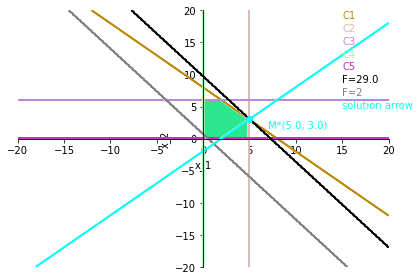

Статус решения: 1, Optimal
Оптимальное значение целевой функции: 29
Оптимальный план: (x1 = 5, x2 = 3)

In [8]:
lp

## Решение матричной задачи симплекс методом

In [9]:
ge = np.vectorize(lambda x, y: x >= y)
le = np.vectorize(lambda x, y: x <= y)


# Решение симплекс-методом
def get_mixed_strategy(M, F_type, C_type_f):
    model = LpProblem("Game", F_type)
    W = []

    for i in range(M.shape[1]):
        w = LpVariable(f'w{i + 1}', lowBound=0)
        W.append(w)



    W = np.array(W)

    F = (W).sum()
    C = C_type_f((M * W).sum(axis=1), 1)

    model += F
    for constraint in C:
        model += constraint

    model.solve()

    opt = np.array(list(map(lambda x: x.value(), model.variables())))

    v = 1 / opt.sum()
    opt = opt / opt.sum()
    return opt, v

In [10]:
def solve_matrix_game(strategies_A, strategies_B, M):
    worst_response_scenarios_A = M.min(axis=1)
    worst_response_scenarios_B = M.max(axis=0)
    opt_strategy_A = worst_response_scenarios_A.argmax() # alpha - нижняя цена игры (максимин) - Это максимальный выигрыш игрока A
    opt_strategy_B = worst_response_scenarios_B.argmin() # beta - верхняя цена игры (минимакс) - Это максимальный проигрыш игрока В


    opt, v = get_mixed_strategy(M.T, LpMinimize, ge)
    opt_b, v_b = get_mixed_strategy(M, LpMaximize, le)

    res = f'a) Оптимальная чистая стратегия для игрока А: №{opt_strategy_A + 1} - {strategies_A[opt_strategy_A]}\n' \
      f'б) Цена игры для игрока А при выборе чистой оптимальной стратегии:  {worst_response_scenarios_A[opt_strategy_A]}\n' \
      f'в) Оптимальная чистая стратегия для игрока Б: №{opt_strategy_B + 1} - {strategies_B[opt_strategy_B]}\n' \
      f'г) Цена игры для игрока Б при выборе чистой оптимальной стратегии: {worst_response_scenarios_B[opt_strategy_B]}\n' \
      f'д) Таблица смешанных стратегий для игрока А: {opt}\n' \
      f'е) Цена игры для игрока А при выборе смешанной оптимальной стратегии: {v}\n' \
      f'ж) Таблица смешанных стратегий для игрока Б: {opt_b}\n' \
      f'з) Цена игры для игрока Б при выборе смешанной оптимальной стратегии: {v_b}'

    print(res)

    return {'A': (opt, v), 'B': (opt_b, v_b)}


In [11]:
A = np.array([
    [10, 7],
    [8, 9],
    [12, 2]
])

In [12]:
solve_matrix_game(["A1", "A2", "A3"], ["B1", "B2"], A)

a) Оптимальная чистая стратегия для игрока А: №2 - A2
б) Цена игры для игрока А при выборе чистой оптимальной стратегии:  8
в) Оптимальная чистая стратегия для игрока Б: №2 - B2
г) Цена игры для игрока Б при выборе чистой оптимальной стратегии: 9
д) Таблица смешанных стратегий для игрока А: [0.25 0.75 0.  ]
е) Цена игры для игрока А при выборе смешанной оптимальной стратегии: 8.49999998725
ж) Таблица смешанных стратегий для игрока Б: [0.5 0.5]
з) Цена игры для игрока Б при выборе смешанной оптимальной стратегии: 8.500000059500001


{'A': (array([0.25, 0.75, 0.  ]), 8.49999998725),
 'B': (array([0.5, 0.5]), 8.500000059500001)}

In [13]:
# Проверка с помощью nashpy
import nashpy

game = nashpy.Game(A)

# Равновесия Нэша
list(game.support_enumeration())

[(array([0.25, 0.75, 0.  ]), array([0.5, 0.5]))]

## Распределение средств между предприятиями (Динамическое программирование - непрерывная)

In [14]:
def solve_dynamic_continuous_problem(s_e, f1, f2, fi1, fi2, n):
    x = LpVariable('x', lowBound=0)
    y = LpVariable('y', lowBound=0)

    # F = f1(x) + f2(y) + f1(fi1(x)) + f2(fi2(y)) + f1(fi1(fi1(x))) + f2(fi2(fi2(y))) # можно написать рекурсией

    def F(acc, w1, w2, n):
        if n == 0:
            return acc
        return F (acc + f1(w1) + f2(w2), fi1(w1), fi2(w2), n-1)


    print(F(0, x, y, n))
    model = LpProblem("Game", LpMaximize)
    model += F(0, x, y, n)

    model += x + y == s_e

    model.solve()

    X = list(map(lambda x: x.value(), model.variables()))
    F_star = model.objective.value()

    return X, F_star




In [15]:
S0 = 5000
f1 = lambda x: 0.3*x # прибыль в конце года 1 предприятия
fi1 = lambda x: 0.1*x  # возврат средств в конце года 1 предприятия

f2 = lambda y: 0.2*y # прибыль в конце года 2 предприятия
fi2 = lambda y: 0.3*y # возврат средств в конце года 2 предприятия
n = 3

In [16]:
solve_dynamic_continuous_problem(S0, f1, f2, fi1, fi2, n)

0.33299999999999996*x + 0.278*y


([5000.0, 0.0], 1664.9999999999998)

# Принцип доминирования и ЛП в играх

Используя принцип доминирования, упростить матрицу игры и найти решение путем сведения к задаче лиенейного программирования

Сокращение матрицы

In [17]:
ge = np.vectorize(lambda x, y: x >= y)
le = np.vectorize(lambda x, y: x <= y)

def reduce_game_matrix(A, f_u):
    A_final = []

    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            if i == j:
                continue

            if f_u(A[i], A[j]).all():
                break
        else:
            A_final.append(A[i])

    A_final = np.array(A_final)
    return np.unique(A_final, axis=0)

In [18]:
A = np.array([
    [2, 2, 1, 4],
    [5, 4, 1, 5],
    [3, 7, 8, 2],
    [5, 2, 1, 3]
])

In [19]:
A_reduced = reduce_game_matrix(reduce_game_matrix(A, le).T, ge).T

In [20]:
A_reduced

array([[2, 7, 8],
       [5, 4, 1]])

In [21]:
strategies_A = list(map(lambda i: f'A{i+1}', range(A.shape[0])))
strategies_B = list(map(lambda i: f'B{i+1}', range(A.shape[1])))

In [22]:
solve_matrix_game(strategies_A, strategies_B, A_reduced)

a) Оптимальная чистая стратегия для игрока А: №1 - A1
б) Цена игры для игрока А при выборе чистой оптимальной стратегии:  2
в) Оптимальная чистая стратегия для игрока Б: №1 - B1
г) Цена игры для игрока Б при выборе чистой оптимальной стратегии: 5
д) Таблица смешанных стратегий для игрока А: [0.4 0.6]
е) Цена игры для игрока А при выборе смешанной оптимальной стратегии: 3.7999999240000015
ж) Таблица смешанных стратегий для игрока Б: [0.70000001 0.         0.29999999]
з) Цена игры для игрока Б при выборе смешанной оптимальной стратегии: 3.7999999528800004


{'A': (array([0.4, 0.6]), 3.7999999240000015),
 'B': (array([0.70000001, 0.        , 0.29999999]), 3.7999999528800004)}

## Парето оптимальное - Последовательные уступки

In [23]:
a = 1
b = 1
c= 1

import sympy as sym
def solve_successive_concessions(f1, f2, f1_type, f2_type, D, u):
    x1 = LpVariable('x1', lowBound=0)
    x2 = LpVariable('x2', lowBound=0)


    # Для f1
    model_f1 = LpProblem(sense=f1_type)
    model_f1 += f1(x1, x2)
    for f_c in D:
        model_f1 += f_c(x1, x2)

    model_f1.solve()

    # Для f2
    model_f2 = LpProblem(sense=f2_type)
    model_f2 += f2(x1, x2)
    for f_c in D:
        model_f2 += f_c(x1, x2)


    f1_star = model_f1.objective.value()
    if f1_type == LpMaximize:
        delta =  f1_star - u * f1_star
        C_f1 = lambda x1, x2: f1(x1, x2) >= delta
    else:
        delta = f1_star + u * f1_star
        C_f1 = lambda x1, x2: f1(x1, x2) <= delta

    model_f2 += C_f1(x1, x2)

    model_f2.solve()



    x1 = sym.Symbol('x1')
    x2 = sym.Symbol('x2')
    C_for_graphic = []
    for C_g in D:
        C_for_graphic.append(C_g(x1, x2))
    C_for_graphic.append(C_f1(x1, x2))
    print(C_for_graphic)


    x1_opt, x2_opt = list(map(lambda x: x.value(), model_f2.variables()))


    p = sym.plot_implicit(sym.And(*C_for_graphic),
                      ('x1', 0, 2 * x1_opt), ('x2', 0, 2 * x2_opt),
                      line_color="#2BE68F",
                      show=False,
                      markers=[{'args': [x1_opt, x2_opt, 'go'], 'color':'r'}]
                      )

    p.annotations = []

    p.annotations.append(
        {'xy': (x1_opt + 0.5, x2_opt), 'text': f'M*({x1_opt}, {x2_opt})', 'ha': 'left', 'va': 'top', 'color': 'red'})

    p.show()

    return ((x1_opt, x2_opt), model_f2.objective.value())




In [24]:
f1 = lambda x1, x2: 5 * x1 + x2
f2 = lambda x1, x2: x1 + 4 * x2

f1_type = LpMaximize
f2_type = LpMaximize

D = [ lambda x1, x2: x1 + x2 <= 8,
      lambda x1, x2: x1 <= 6,
      lambda x1, x2: x2 <= 5,
      lambda x1, x2: x1 >= 0,
      lambda x1, x2: x2 >= 0
      ]




[x1 + x2 <= 8, x1 <= 6, x2 <= 5, x1 >= 0, x2 >= 0, 5*x1 + x2 >= 28.8]


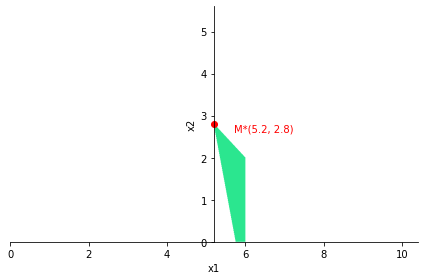

((5.2, 2.8), 16.4)

In [25]:
solve_successive_concessions(f1, f2, f1_type, f2_type, D, 0.1)

In [26]:
f1 = lambda x1, x2: 3 * x1 + x2
f2 = lambda x1, x2: x1 + 2 * x2

f1_type = LpMaximize
f2_type = LpMaximize

D = [ lambda x1, x2: x1 + x2 <= 8,
      lambda x1, x2: x1 <= 5,
      lambda x1, x2: x2 <= 6,
      lambda x1, x2: x1 >= 0,
      lambda x1, x2: x2 >= 0
      ]

[x1 + x2 <= 8, x1 <= 5, x2 <= 6, x1 >= 0, x2 >= 0, x1 + 2*x2 >= 12.6]


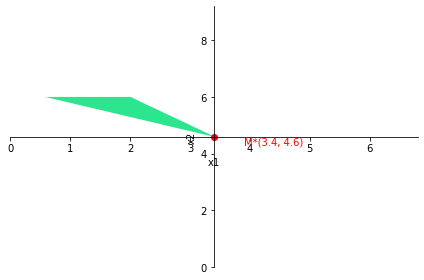

((3.4, 4.6), 14.799999999999999)

In [27]:
solve_successive_concessions(f2, f1, f1_type, f2_type, D, 0.1)

## Метод иделальной точки - Сделано при помощи LP

In [28]:
a = 1
b = 1
c= 1

f1 = sym.parse_expr('4 * x_1 + x_2')
f2 = sym.parse_expr("x_1 + 3 * x_2")

F = f1 + f2

D = ['x_1 + x_2 <= 9',
      'x_1 <= 6',
      'x_2 <= 7',
      'x_1 >= 0',
     'x_2 >= 0'
     ]

lp = LP(D, F, a, b, c)

Eq(5*x_1 + 4*x_2, 42.0)


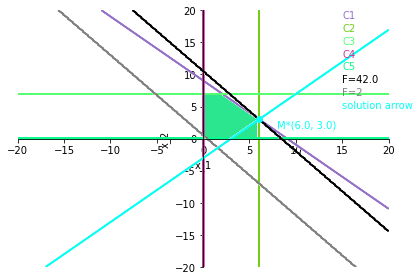

Статус решения: 1, Optimal
Оптимальное значение целевой функции: 42
Оптимальный план: (x1 = 6, x2 = 3)

In [29]:
lp

## Графическое решение матричной игры в смешанных стратегиях

In [30]:
def get_func_by_points(p1, p2):
    return lambda x: (x - p1[0]) * (p2[1] - p1[1]) / (p2[0] - p1[0]) + p1[1]


def solve_matrix_game_graphic_method(A, inverse=False):

    A_origin = A

    if inverse:
        x_name = 'B'
        y_name = 'A'
        ueq = ge
        A = A.T
        obj = 'B'
        strategy_s = 'q'
    else:
        x_name = 'A'
        y_name = 'B'
        ueq = le
        obj = 'A'
        strategy_s = 'p'

    offset = 0.05

    x_sym = sym.Symbol('x')
    y_sym = sym.Symbol('y')
    plot_main = sym.plot(show=False, xlim=(0 - offset, 1 + offset), ylim=(0 - offset, A.max() + offset))


    B = A.T
    B_points = []
    for i in range(B.shape[0]):
        p = []
        for j in range(B.shape[1]):
            p.append([j, B[i, j]])
        B_points.append(p)


    def print_straight(p, v, v_name, color):
        f = get_func_by_points(*v)
        p.append(
            sym.plot(f(x_sym),
                     show=False,
                     line_color=color)[0])
        return f

    b_funcs = []


    for i in range(len(B_points)):
        b_f = print_straight(plot_main, np.array(B_points[i]), f'{y_name}{i + 1}', 'red')
        b_funcs.append(b_f)

    plot_main.append(
        sym.plot_implicit(
            sym.And(*map(lambda f: ueq(y_sym, f(x_sym)), b_funcs)),
            ('x',0, 1),
            ('y',0, 20),
            show=False,
            line_color="#2BE68F",
        )[0])

    plot_main.append(sym.plot(0, show=False, line_color='blue')[0])

    plot_main.markers = []
    plot_main.annotations = []
    for i in range(len(B_points)):
        for x, y in B_points[i]:
            plot_main.markers.append({'args': [x, y, 'go'], 'color':'red'})

            plot_main.annotations.append(
                 {'xy': (x + offset, y), 'text': f'{y_name}{i+1}', 'ha': 'left', 'va': 'top', 'color': 'red'}
            )

    plot_main.annotations.extend([
        {'xy': (0 + offset, 0 + offset), 'text': f'{x_name}1', 'ha': 'left', 'va': 'top', 'color': 'blue'},
        {'xy': (1 - offset, 0 + offset), 'text': f'{x_name}2', 'ha': 'left', 'va': 'top', 'color': 'blue'}
    ]
    )

    plot_main.markers.extend(
        [{'args': [0, 0, 'go'], 'color':'blue'},
         {'args': [1, 0, 'go'], 'color':'blue'}]
    )


    opt, v = solve_matrix_game(['A1', 'A2'], ['B1', 'B2', 'B3'], A_origin)[obj]
    print(v)


    plot_line = sym.plot_implicit(sym.And(sym.Eq(x_sym, opt[1])), ('x', 0, 10), ('y', 0, v), show=False, line_color='gold')[0]

    plot_main.markers.append({'args': [opt[1], v, 'go'], 'color':'gold'})
    plot_main.annotations.append({'xy': (opt[1] + offset, v + offset), 'text': f'M*{opt[1], v}', 'ha': 'left', 'va': 'top', 'color': 'gold'})

    plot_main.markers.append({'args': [opt[1], 0, 'go'], 'color':'gold'})
    plot_main.annotations.append({'xy': (opt[1] + offset, 0 + offset), 'text': f'S_A* = {opt[1]} = {strategy_s}2', 'ha': 'left', 'va': 'top', 'color': 'gold'})

    plot_main.append(plot_line)
    plot_main.show()

In [31]:
A = np.array([
    [11, 5, 1],
    [6, 10, 15]
])

In [32]:
A = np.array([
    [10, 7],
    [8, 9],
    [12, 2]
])

a) Оптимальная чистая стратегия для игрока А: №2 - A2
б) Цена игры для игрока А при выборе чистой оптимальной стратегии:  8
в) Оптимальная чистая стратегия для игрока Б: №2 - B2
г) Цена игры для игрока Б при выборе чистой оптимальной стратегии: 9
д) Таблица смешанных стратегий для игрока А: [0.25 0.75 0.  ]
е) Цена игры для игрока А при выборе смешанной оптимальной стратегии: 8.49999998725
ж) Таблица смешанных стратегий для игрока Б: [0.5 0.5]
з) Цена игры для игрока Б при выборе смешанной оптимальной стратегии: 8.500000059500001
8.500000059500001


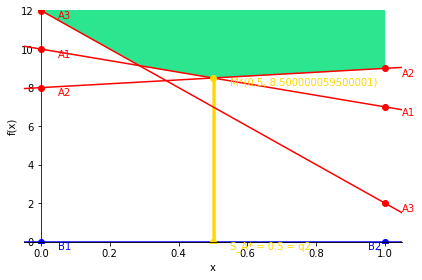

In [33]:
solve_matrix_game_graphic_method(A, inverse=True)

## Метод идеальной точки

In [34]:
a = 1
b = 1
c= 1

f1 = sym.parse_expr('4 * x_1 + x_2')
f2 = sym.parse_expr("x_1 + 5 * x_2")

F = f1 - f2

D = ['x_1 + x_2 <= 10',
      'x_1 <= 7',
      'x_2 <= 8',
      'x_1 >= 0',
     'x_2 >= 0'
     ]

lp = LP(D, F, a, b, c)

Eq(3*x_1 - 4*x_2, 21.0)


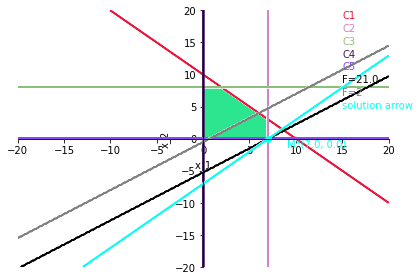

Статус решения: 1, Optimal
Оптимальное значение целевой функции: 21
Оптимальный план: (x1 = 7, x2 = 0)

In [35]:
lp

## Метод минимального тарифа

In [36]:
def get_plan_by_min_tariff_method(M, A, B):


    a_total = A.sum()
    b_total = B.sum()

    sorted_indexes = list(sorted(((i, j) for j in range(M.shape[1]) for i in range(M.shape[0])), key=lambda x: M[x[0], x[1]]))

    X_star = np.zeros(M.shape)
    A = A.copy()
    B = B.copy()

    for i, j in sorted_indexes:
        if B[j] > 0 and A[i] > 0:
            X_star[i, j] = min(A[i], B[j])
            A[i] -= X_star[i, j]
            B[j] -= X_star[i, j]

            a_total -= X_star[i, j]
            b_total -= X_star[i, j]
        if a_total == 0 or b_total == 0:
            break

    return X_star

In [37]:
inf = 1000

M = np.array([
    [inf, inf, 12, 3],
    [7, 8, 9, 10],
    [7, 11, 6, 6]
])

A = np.array([50, 90, 110])
B = np.array([110, 20, 20, 100])

In [38]:
X_star = get_plan_by_min_tariff_method(M, A, B)
X_star

array([[ 0.,  0.,  0., 50.],
       [90.,  0.,  0.,  0.],
       [20., 20., 20., 50.]])

In [39]:
print(f"Общая стоимость перевозок: {(X_star * M).sum()}")

Общая стоимость перевозок: 1560.0


## Метод аппроксимации Фогеля

In [40]:
def get_plan_by_fogel_approximations(M, A, B):
    M = M.copy()
    A = A.copy()
    B = B.copy()

    inf = 1000
    fogel_m = np.zeros((M.shape[0] + 1, M.shape[1] + 1))

    a_total = A.sum()
    b_total = B.sum()

    while a_total > 0 and b_total > 0:
        v1 = np.argsort(M, axis=1)
        v2 = np.argsort(M, axis=0)

        for i in range(len(v1)):
            fogel_m[i, -1] = M[i, v1[i, 1]] - M[i, v1[i, 0]]

        for j in range(len(v2)):
            fogel_m[-1, j] = M[v2[j, 1], j] - M[v2[j, 0], j]

        max_i = fogel_m[:, -1].argmax()
        max_j = fogel_m[-1, :].argmax()

        if fogel_m[max_i, -1] > fogel_m[-1,max_j]:
            i, j = max_i, v1[max_i, 0]
            fogel_m[max_i, -1] = 0
        else:
            i, j = v2[max_j, 0], max_j
            fogel_m[-1, max_j] = 0

        fogel_m[i, j] = min(A[i], B[j])

        A[i] -= fogel_m[i, j]
        B[j] -= fogel_m[i, j]
        M[i, j] = inf

        a_total -= fogel_m[i, j]
        b_total -= fogel_m[i, j]

    return fogel_m[:M.shape[0], :M.shape[1]]




In [41]:
M = np.array([
    [2, 3, 6, 4],
    [4, 1, 5, 7],
    [5, 2, 3, 3],
])

A = np.array([36, 55, 80])
B = np.array([30, 55, 44, 42])

In [42]:
X_star = get_plan_by_fogel_approximations(M, A, B)

In [43]:
X_star

array([[30.,  0.,  0.,  6.],
       [ 0., 55.,  0.,  0.],
       [ 0.,  0., 44., 36.]])

In [44]:
(X_star * M).sum()

379.0

In [45]:
X_star = get_plan_by_min_tariff_method(M, A, B)
print(X_star)
print((M * X_star).sum())

[[30.  0.  0.  6.]
 [ 0. 55.  0.  0.]
 [ 0.  0. 44. 36.]]
379.0


In [46]:
solve_transport_lp_method(M, A, B)

Оптимальный план перевозки:
[[30.  0.  0.  6.]
 [ 0. 55.  0.  0.]
 [ 0.  0. 44. 36.]]
Оптимальная стоимость перевозки: 379.0


In [47]:
M = np.array([
    [1, 3, 5, 4],
    [5, 3, 1, 2],
    [2, 1, 4, 2]
])

A = np.array([100, 50, 40])
B = np.array([70, 30, 20, 40])


get_plan_by_min_tariff_method(M, A, B)

array([[70.,  0.,  0.,  0.],
       [ 0.,  0., 20., 30.],
       [ 0., 30.,  0., 10.]])

In [48]:
solve_transport_lp_method(M, A, B)

Оптимальный план перевозки:
[[70.  0.  0.  0.]
 [ 0.  0. 20. 30.]
 [ 0. 30.  0. 10.]]
Оптимальная стоимость перевозки: 200.0


In [49]:
A = np.array([
    [13, 7, 5],
    [9, 10, 16]
])

solve_matrix_game(['A1', 'A2'], ['B1', 'B2', 'B3'], A)

a) Оптимальная чистая стратегия для игрока А: №2 - A2
б) Цена игры для игрока А при выборе чистой оптимальной стратегии:  9
в) Оптимальная чистая стратегия для игрока Б: №2 - B2
г) Цена игры для игрока Б при выборе чистой оптимальной стратегии: 10
д) Таблица смешанных стратегий для игрока А: [0.14285714 0.85714286]
е) Цена игры для игрока А при выборе смешанной оптимальной стратегии: 9.571428565959183
ж) Таблица смешанных стратегий для игрока Б: [0.42857142 0.57142858 0.        ]
з) Цена игры для игрока Б при выборе смешанной оптимальной стратегии: 9.571428565959184


{'A': (array([0.14285714, 0.85714286]), 9.571428565959183),
 'B': (array([0.42857142, 0.57142858, 0.        ]), 9.571428565959184)}

In [55]:
S0 = 10000
f1 = lambda x: 0.7*x # прибыль в конце года 1 предприятия
fi1 = lambda x: 0.6*x  # возврат средств в конце года 1 предприятия

f2 = lambda y: 0.6*y # прибыль в конце года 2 предприятия
fi2 = lambda y: 0.8*y # возврат средств в конце года 2 предприятия
n = 3

In [56]:
solve_dynamic_continuous_problem(S0, f1, f2, fi1, fi2, n)

1.3719999999999999*x + 1.4640000000000002*y


([0.0, 10000.0], 14640.000000000002)